# PyDMD

### Tutorial 3: Multiresolution DMD: different time scales

In this tutorial we will show the possibilities of the multiresolution dynamic modes decomposition (mrDMD) with respect to the classical DMD. We follow a wonderful blog post written by Robert Taylor [available here](http://www.pyrunner.com/weblog/2016/08/05/mrdmd-python/). We did not use his implementation of the mrDMD but only the sample data and the structure of the tutorial. You can find a mathematical reference for the mrDMD by Kutz et al. [here](http://epubs.siam.org/doi/pdf/10.1137/15M1023543). 
For the advanced settings of the DMD base class please refer to [this tutorial](https://github.com/mathLab/PyDMD/blob/master/tutorials/tutorial-2-adv-dmd.ipynb).

First of all we just import the MrDMD and DMD classes from the pydmd package, we set matplotlib for the notebook and we import numpy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pydmd import MrDMD, DMD
from pydmd.plotter import plot_eigs_mrdmd
import numpy as np

The code below generates a spatio-temporal example dataset. The data can be thought of as 80 locations or signals (the x-axis) being sampled 1600 times at a constant rate in time (the t-axis). It contains many features at varying time scales, like oscillating sines and cosines, one-time events, and random noise. 

In [2]:
def create_sample_data():
    x = np.linspace(-10, 10, 80)
    t = np.linspace(0, 20, 1600)
    Xm, Tm = np.meshgrid(x, t)

    D = np.exp(-np.power(Xm / 2, 2)) * np.exp(0.8j * Tm)
    D += np.sin(0.9 * Xm) * np.exp(1j * Tm)
    D += np.cos(1.1 * Xm) * np.exp(2j * Tm)
    D += 0.6 * np.sin(1.2 * Xm) * np.exp(3j * Tm)
    D += 0.6 * np.cos(1.3 * Xm) * np.exp(4j * Tm)
    D += 0.2 * np.sin(2.0 * Xm) * np.exp(6j * Tm)
    D += 0.2 * np.cos(2.1 * Xm) * np.exp(8j * Tm)
    D += 0.1 * np.sin(5.7 * Xm) * np.exp(10j * Tm)
    D += 0.1 * np.cos(5.9 * Xm) * np.exp(12j * Tm)
    D += 0.1 * np.random.randn(*Xm.shape)
    D += 0.03 * np.random.randn(*Xm.shape)
    D += (
        5
        * np.exp(-np.power((Xm + 5) / 5, 2))
        * np.exp(-np.power((Tm - 5) / 5, 2))
    )
    D[:800, 40:] += 2
    D[200:600, 50:70] -= 3
    D[800:, :40] -= 2
    D[1000:1400, 10:30] += 3
    D[1000:1080, 50:70] += 2
    D[1160:1240, 50:70] += 2
    D[1320:1400, 50:70] += 2
    return D.T

Here we have an auxiliary function that we will use to plot the data.

In [3]:
def make_plot(X, x=None, y=None, figsize=(12, 8), title=""):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, y, X)
    cbar = plt.colorbar(CS)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.show()

Let us start by creating the dataset and plot the data in order to have a first idea of the problem. 

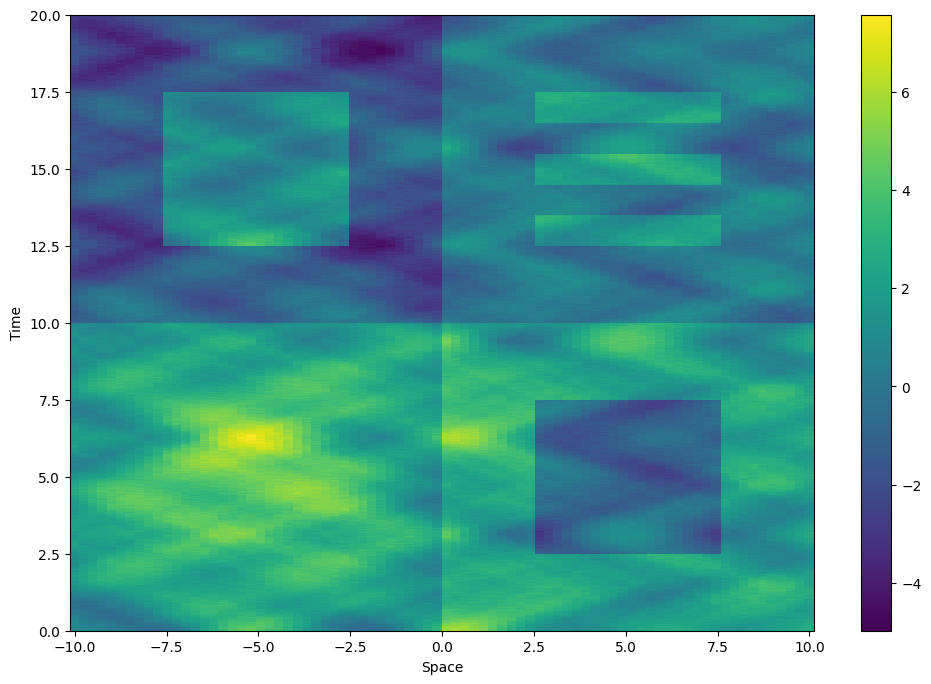

In [4]:
sample_data = create_sample_data()
x = np.linspace(-10, 10, 80)
t = np.linspace(0, 20, 1600)
make_plot(sample_data.T, x=x, y=t)

First we apply the classical DMD without the svd rank truncation, and then we try to reconstruct the data. You can clearly see that all the transient time events are missing.

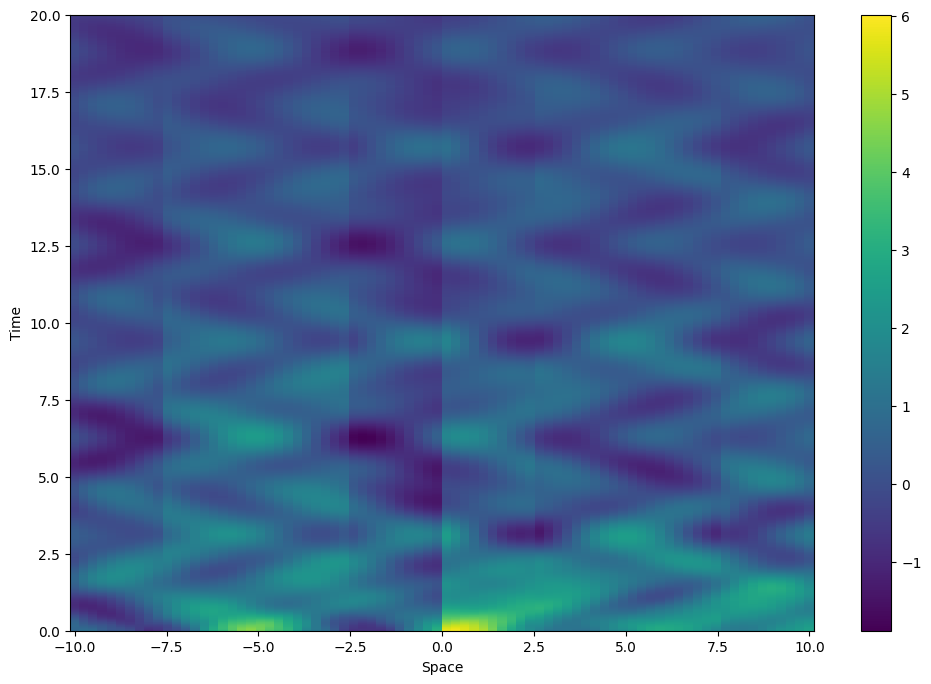

In [5]:
first_dmd = DMD(svd_rank=-1)
first_dmd.fit(X=sample_data)
make_plot(first_dmd.reconstructed_data.T, x=x, y=t)

Now we do the same but using the mrDMD instead. The result is remarkable even with the svd rank truncation (experiment changing the input parameters).

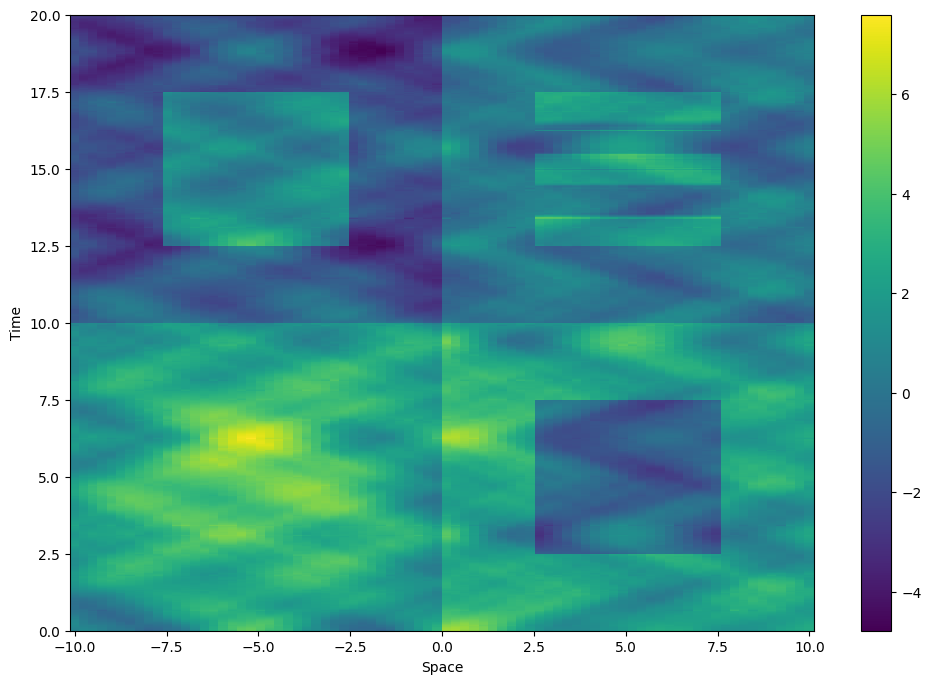

In [6]:
sub_dmd = DMD(svd_rank=-1)

dmd = MrDMD(sub_dmd, max_level=7, max_cycles=1)
dmd.fit(X=sample_data)
make_plot(dmd.reconstructed_data.T, x=x, y=t)

Ok, pretty amazing eh? Let us have a look at the eigenvalues in order to better understand the mrDMD. Without truncation we have 80 eigenvalues.

The number of eigenvalues is 406


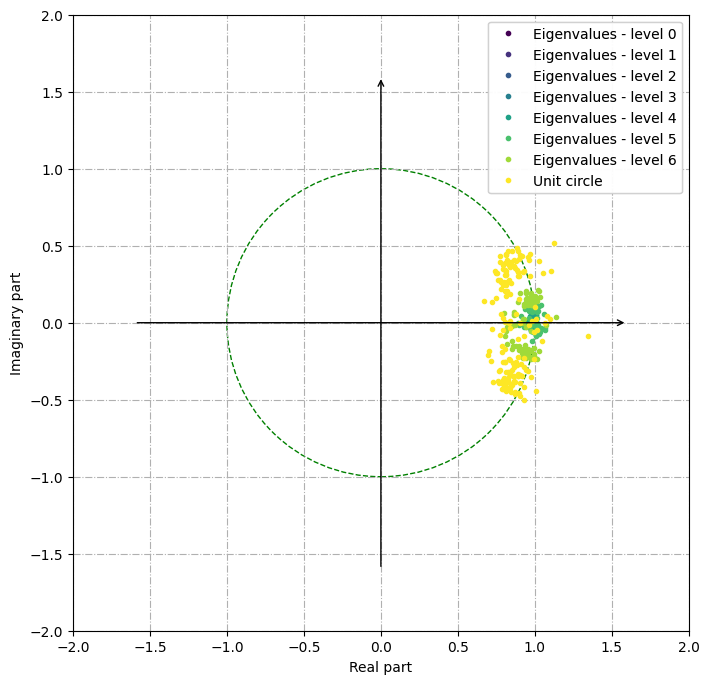

In [7]:
print("The number of eigenvalues is {}".format(dmd.eigs.shape[0]))
plot_eigs_mrdmd(dmd, show_axes=True, show_unit_circle=True, figsize=(8, 8))

It is also possible to plot only specific eigenvalues, given the level and the node. If the node is not provided all the eigenvalues of that level will be plotted.

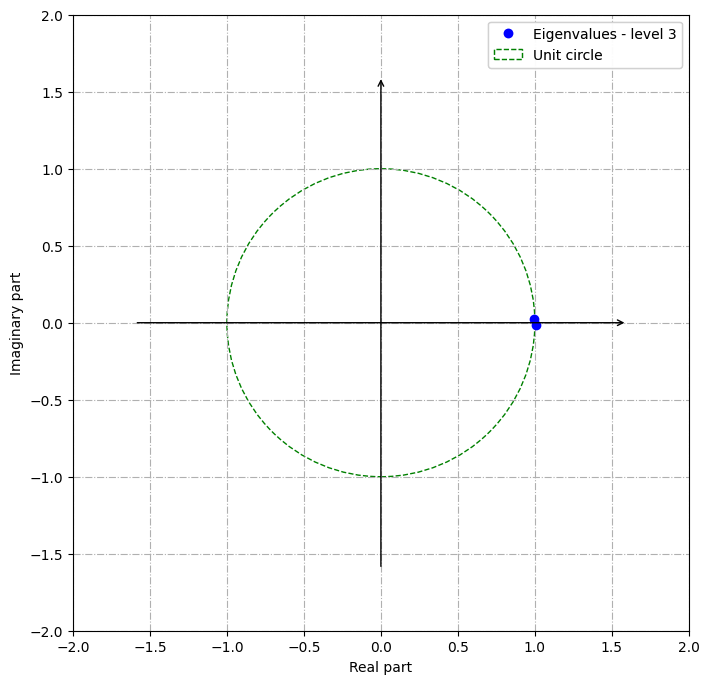

In [8]:
plot_eigs_mrdmd(
    dmd, show_axes=True, show_unit_circle=True, figsize=(8, 8), level=3, node=0
)

The idea is to extract the slow modes at each iteration, where a slow mode is a mode with a relative low frequency. This just means that the mode changes somewhat slowly as the system evolves in time. Thus the mrDMD is able to catch different time events.

The general mrDMD algorithm is as follows:

1. Compute DMD for available data.
2. Determine fast and slow modes.
3. Find the best DMD approximation to the available data constructed from the slow modes only.
4. Subtract off the slow-mode approximation from the available data.
5. Split the available data in half.
6. Repeat the procedure for the first half of data (including this step).
7. Repeat the procedure for the second half of data (including this step).

Let us have a look at the modes for the first two levels and the corresponding time evolution. At the first level we have two very slow modes, while at the second one there are 5 modes. 

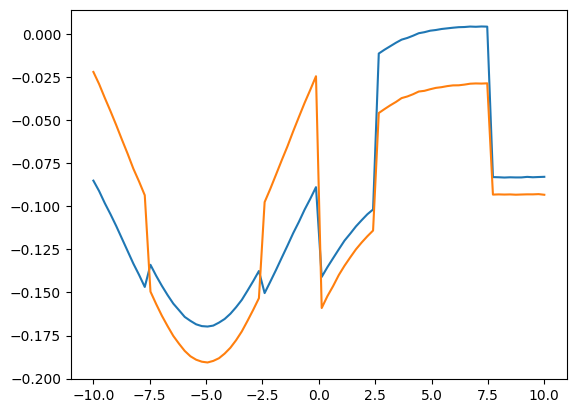

In [9]:
pmodes = dmd.partial_modes(level=0)
fig = plt.plot(x, pmodes.real)

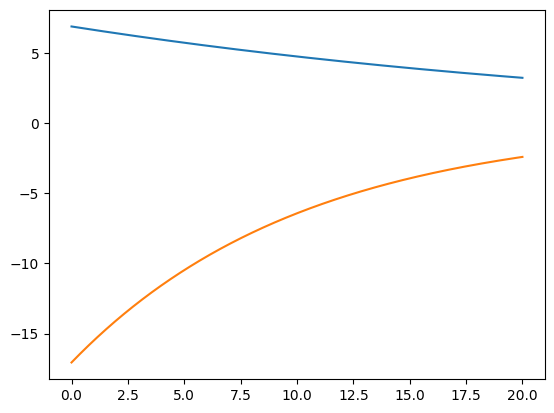

In [10]:
pdyna = dmd.partial_dynamics(level=0)
fig = plt.plot(t, pdyna.real.T)

Notice the discontinuities in the time evolution where the data were split. 

The number of modes in the level number 1 is 3


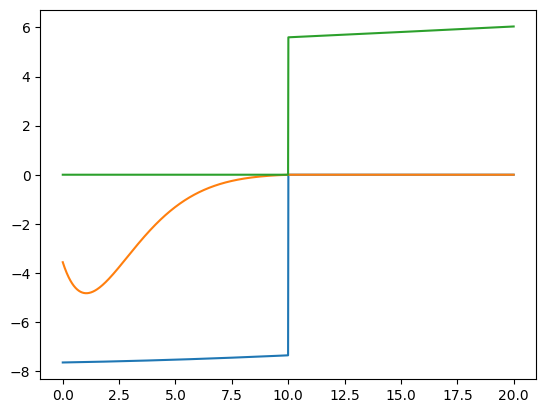

In [11]:
pdyna = dmd.partial_dynamics(level=1)
print("The number of modes in the level number 1 is {}".format(pdyna.shape[0]))
fig = plt.plot(t, pdyna.real.T)

Now we recreate the original data by adding levels together. For each level, starting with the first (note that the starting index is 0), we construct an approximation of the data. 

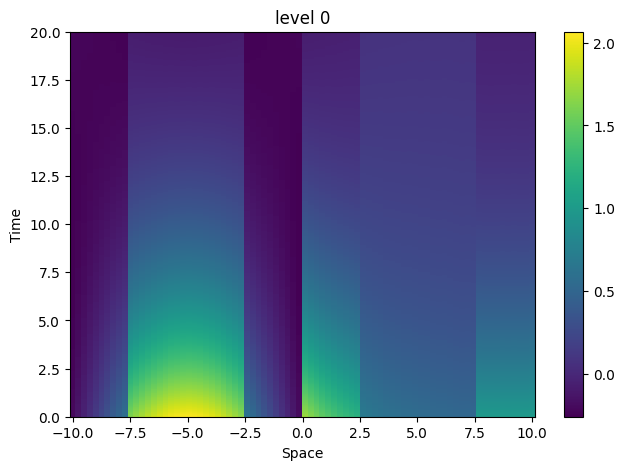

In [12]:
pdata = dmd.partial_reconstructed_data(level=0)
make_plot(pdata.T, x=x, y=t, title="level 0", figsize=(7.5, 5))

Then, we sequentially add them all together, one on top of another. It is interesting to see how the original data has been broken into features of finer and finer resolution.

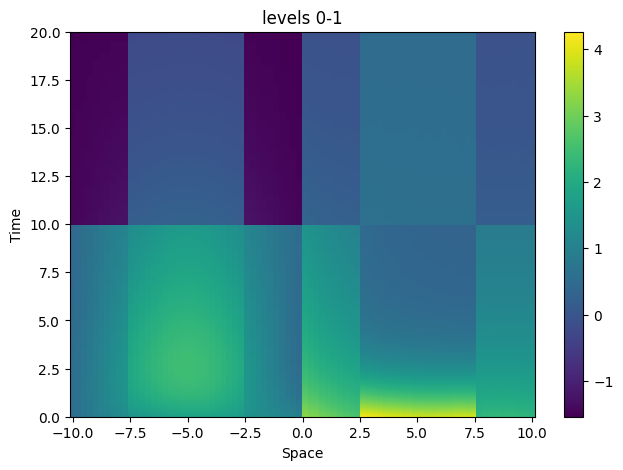

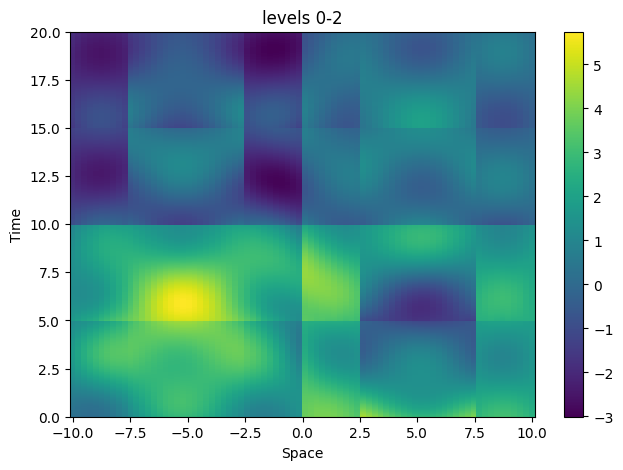

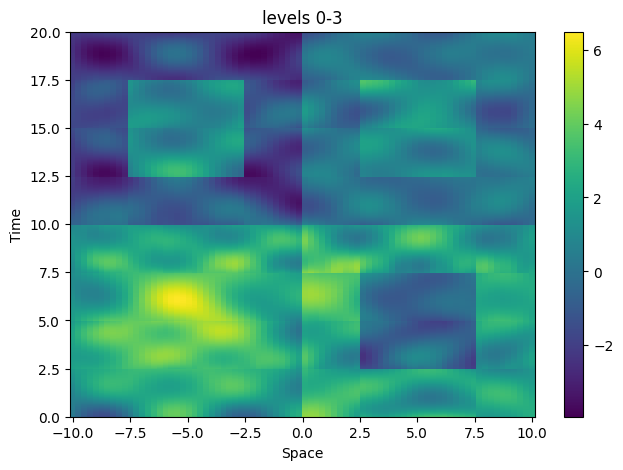

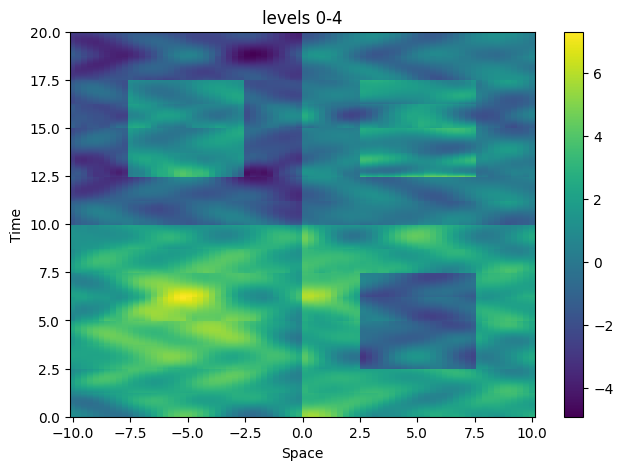

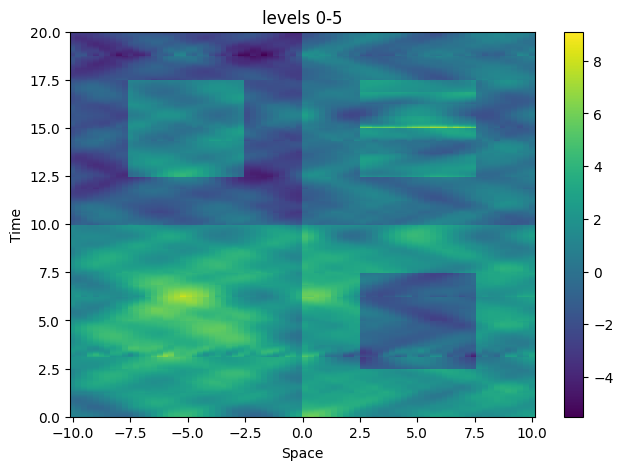

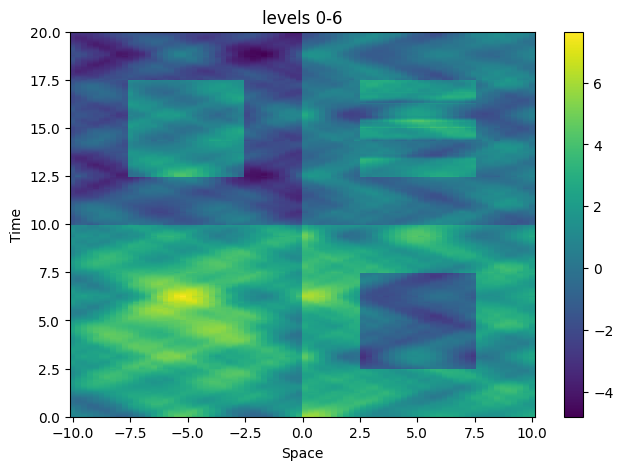

In [13]:
for i in range(1, 7):
    pdata += dmd.partial_reconstructed_data(level=i)
    make_plot(pdata.T, x=x, y=t, title="levels 0-" + str(i), figsize=(7.5, 5))

The multiresolution DMD has been employed in many different fields of study due to its versatility. Feel free to share with us your applications!